# Text Classification by CNN

In [1]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

## Word2Vec 转化为矩阵 

In [4]:
import pandas as pd
# import nltk
import string
# import re
import numpy as np
import random

In [6]:
data=pd.read_table('train.tsv',sep='\t')
# texts=data['Phrase'].tolist()
data_y=data["Sentiment"]
data_y=np.array(data_y)
N=len(data_y)

In [ ]:
#string.punctuation中包含英文的标点，我们将其放在待去除变量remove中
#函数需要三个参数，前两个表示字符的映射，我们是不需要的。
# remove = str.maketrans('','',string.punctuation) 
# x = data_x[0].translate(remove)
# x
# len(x.split())
# len(nltk.word_tokenize(x))

stopwords = ('-',',','.',';',':',"'")  # 停词
stoptags = ['CC','CD','IN','TO','PRP','PDT','DT','PRP$','WRB'] # 词性

words_ls = []
i=1
for text in texts:
    if i%100 == 0:
        print("当前已完成%.2f" % (i*100/156060)+'%',end='\r')
    words = [word for word in nltk.word_tokenize(text) if (word not in stopwords) and re.findall(re.compile(r'\d+'),word)==[] and (nltk.pos_tag([word])[0][1] not in stoptags)]
    words_ls.append(words)
    i+=1

In [ ]:
# with open("words_ls.txt","w") as f:
#     for words in words_ls:
#         f.write(str(words)+"\n")

In [7]:
stopwords = ('-',',','.',';',':',"'",'?')  # 停词

texts=data['Phrase'].tolist()
words_ls2 = []
i=1
for text in texts:
    remove = str.maketrans('','',string.punctuation) 
    text = text.translate(remove)
    if i%100 == 0:
        print("当前已完成%.2f" % (i*100/156060)+'%',end='\r')
    words = [word for word in text.split() if (word not in stopwords)]
    words_ls2.append(words)
    i+=1

# with open("words_ls2.txt","w") as f:
#     for words in words_ls2:
#         f.write(str(words)+"\n")

In [ ]:
words_ls=pd.read_table('words_ls.txt',header=None)[0]
words_ls=[eval(words) for words in words_ls]

word_maxlen=0
for words in words_ls:
    word_maxlen=max(word_maxlen,len(words))

## 构建CNN框架

In [ ]:
import torch
import torch.nn as nn
import torchvision
# import matplotlib.pyplot as plt
# %matplotlib inline
import torch.utils.data as Data

In [ ]:
# Hyper Parameters
LEN_SEN = word_maxlen
VEC_LEN = 300

In [ ]:
class CNN(nn.Module):
    def __init__(self,n_window = 3,vec_len=300):
        self.window = n_window
        self.vec_len = vec_len
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=(self.window,self.vec_len),              # filter size
                stride=(1,self.vec_len),                   # filter movement/step
                # padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=(LEN_SEN-self.window+1,1),stride=(LEN_SEN-self.window+1,1)),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )

        self.out = nn.Linear(16, 5)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
cnn = CNN(vec_len=200)
print(cnn)  # net architecture

### 生成训练集batch

In [ ]:
wordvec=np.zeros([BATCH_SIZE,1,word_maxlen,300]) # dimension 
for i in range(BATCH_SIZE):
    words=words_ls[i]
    n=len(words)
    if n>0: 
        try:
            wordvec[i,0,:n,:]=word2vec[words]
        except KeyError:
            for h in range(n):
                try:
                    wordvec[i,0,h,:]=word2vec[words[h]].reshape(1,300)
                except KeyError:
                    wordvec[i,0,h,:]=np.random.randn(1,300)/10

# 到此 wordvec的type还是np.array
# need to convert to torch.tensor

In [ ]:
def wv_to_tensor(inds,t_height=word_maxlen,v_length=VEC_LEN,WV=word2vec):
    l=len(inds)
    wordvec=np.zeros([l,1,t_height,v_length]) # dimension 
    for i in range(l):
        words=words_ls[inds[i]]
        n=len(words)
        if n>0: 
            try:
                wordvec[i,0,:n,:]=WV[words]
            except KeyError:
                for h in range(n):
                    try:
                        wordvec[i,0,h,:]=WV[words[h]].reshape(1,v_length)
                    except KeyError:
                        wordvec[i,0,h,:]=np.random.randn(1,v_length)/10
                        # 到此 wordvec的type还是np.array, need to convert to torch.tensor
    return torch.from_numpy(wordvec).to(torch.float32)

In [ ]:
cnn=CNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

cnn(wv_to_tensor(inds=[1,2,3,4]))
data_y[:4]

loss=loss_func(cnn(wv_to_tensor(inds=[1,2,3,4]))[0],torch.from_numpy(data_y[:4]))
loss
optimizer.zero_grad()           # clear gradients for this training step
loss.backward()                 # backpropagation, compute gradients
optimizer.step()                # apply gradients

In [ ]:
# # test chunk
# mat=np.concatenate((np.arange(100).reshape(100,1),np.random.randint(5,size=100).reshape(100,1)),axis=1)
# train_loader = Data.DataLoader(dataset=mat, batch_size=5, shuffle=True)

# for step,x in enumerate(train_loader):
#     if step%5==0:
#         print('step'+str(step)+"|"+str(x))
#         x[:,0].numpy()

## Train/Test by Google WV

In [ ]:
# Hyper Parameters
EPOCH = 2   
BATCH_SIZE = 200
LR = 0.01  # learning rate

### window = 2

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN(n_window=2)
# cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

train_inds=random.sample(range(N),np.int(np.floor(N*0.8)))
test_inds=list(set(range(N))-set(train_inds))

# training and testing

mat=np.concatenate((np.arange(N).reshape(N,1),data_y.reshape(N,1)),axis=1)
train_loader = Data.DataLoader(dataset=mat[train_inds,:], batch_size=BATCH_SIZE, shuffle=True)
test_x=wv_to_tensor(mat[test_inds,0])
test_y=torch.from_numpy(mat[test_inds,1])

for epoch in range(EPOCH):
    for step, batch_data in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x_ind = batch_data[:,0]  # batch x
        b_y = batch_data[:,1]   # batch y
        b_x = wv_to_tensor(b_x_ind)

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)

In [ ]:
torch.save(cnn, 'cnn-w2.pkl')  # save entire net
# torch.save(net1.state_dict(), 'net_params.pkl')   # save only the parameters

In [ ]:
test_output, last_layer = cnn(test_x)
torch.max(test_output, 1)[1].data.squeeze()
(pred_y == test_y).sum().item() / float(test_y.size(0))

### window = 3 

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = CNN(n_window=3)
# cnn.to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

train_inds=random.sample(range(N),np.int(np.floor(N*0.8)))
test_inds=list(set(range(N))-set(train_inds))

# training and testing

mat=np.concatenate((np.arange(N).reshape(N,1),data_y.reshape(N,1)),axis=1)
train_loader = Data.DataLoader(dataset=mat[train_inds,:], batch_size=BATCH_SIZE, shuffle=True)
test_x=wv_to_tensor(mat[test_inds,0])
test_y=torch.from_numpy(mat[test_inds,1])

for epoch in range(EPOCH):
    for step, batch_data in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x_ind = batch_data[:,0]  # batch x
        b_y = batch_data[:,1]   # batch y
        b_x = wv_to_tensor(b_x_ind)

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)

In [ ]:
torch.save(cnn, 'cnn-w3.pkl')  # save entire net

### Functionalize

In [ ]:
def train(EPOCH = 2 ,BATCH_SIZE = 200,LR = 0.01,n_window = 3,wv=word2vec):
    
    cnn = CNN(n_window)
    optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
    loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

    train_inds=random.sample(range(N),np.int(np.floor(N*0.8)))
    test_inds=list(set(range(N))-set(train_inds))

    mat=np.concatenate((np.arange(N).reshape(N,1),data_y.reshape(N,1)),axis=1)
    train_loader = Data.DataLoader(dataset=mat[train_inds,:], batch_size=BATCH_SIZE, shuffle=True)
    test_x=wv_to_tensor(inds=mat[test_inds,0],WV=wv)
    test_y=torch.from_numpy(mat[test_inds,1])

    for epoch in range(EPOCH):
        for step, batch_data in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
            b_x_ind = batch_data[:,0]  # batch x
            b_y = batch_data[:,1]   # batch y
            b_x = wv_to_tensor(inds=b_x_ind,WV=wv)

            output = cnn(b_x)[0]               # cnn output
            loss = loss_func(output, b_y)   # cross entropy loss
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients

            if step % 100 == 0:
                test_output, last_layer = cnn(test_x)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
                print('Epoch: ', epoch, '| Step: ', step, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)
    return (cnn,accuracy)

In [ ]:
cnn4,acc4=train(n_window=4,wv=word2vec)

In [ ]:
torch.save(cnn4, 'cnn-w4.pkl')  # save entire net

In [ ]:
cnn5,acc5=train(n_window=5,wv=word2vec)

In [ ]:
torch.save(cnn5, 'cnn-w5.pkl')  # save entire net

In [ ]:
cnn10,acc10=train(n_window=10,wv=word2vec)

## Train/Test by Reuters WV

## Evaluation

In [ ]:
test_inds=random.sample(range(N),np.int(np.floor(N*0.2)))

mat=np.concatenate((np.arange(N).reshape(N,1),data_y.reshape(N,1)),axis=1)

test_x=wv_to_tensor(inds=mat[test_inds,0],WV=word2vec)
test_y=torch.from_numpy(mat[test_inds,1])

In [ ]:
net = torch.load('cnn-w2.pkl')

In [ ]:
test_output, last_layer = net(test_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()

round((pred_y == test_y).sum().item() / float(test_y.size(0)),4)

## Plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cnn_acc=np.array([[0.632,0.6486,0.6477,0.6601,0.652,0.6602],
                 [0.5161,0.5207,0.5185,0.5237,0.5182 ,0.5174],
                 [0.5184,0.5169,0.5200,0.5146,0.5208,0.5211],
                 [0.5397,0.5360,0.5375,0.5361,0.5409,0.5400],
                 [0.5451,0.5360,0.5347,0.5355,0.5294,0.5346],
                 [0.5995,0.6035,0.6071,0.6012,0.6060,0.6086],
                 [0.6195,0.6273,0.6301,0.6212,0.6259,0.6234]])
labs=['GoogleNews-300','Reuters-100','Reuters-300','ThisDoc-100','ThisDoc-300','GloVe-100','GloVe-300']
x=np.array([2,3,4,5,7,10])

<Figure size 576x360 with 0 Axes>

(0.5, 0.73)

Text(0.5, 0, 'convolution window')

Text(0, 0.5, 'test accuracy')

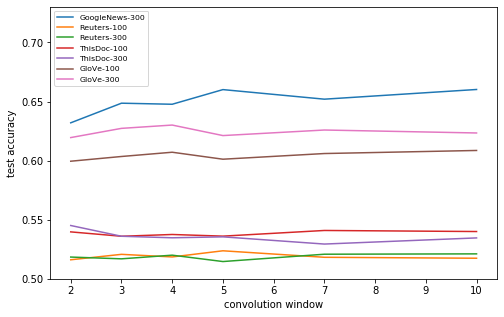

In [34]:
plt.figure(num=1, figsize=(8, 5))

l=plt.plot(x,cnn_acc.T)
plt.ylim((0.5, 0.73))
plt.legend(handles=l,labels=labs,loc='upper left',prop = {'size':7.8})
plt.xlabel('convolution window')
plt.ylabel('test accuracy')
plt.savefig('cnn.png')
plt.show()

<Figure size 576x360 with 0 Axes>

(0.5, 0.7)

<BarContainer object of 5 artists>

Text(0.5, 0, 'word vector')

Text(0, 0.5, 'test accuracy')

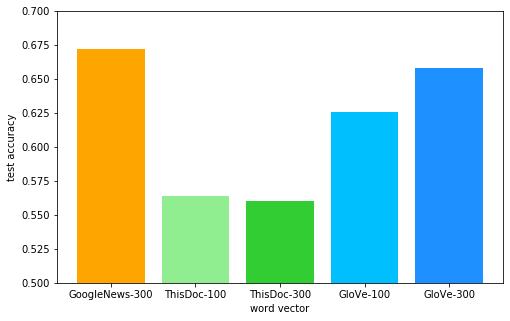

In [47]:
x=np.array([0.6721,0.5638,0.5601,0.6258,0.6583])
labs=['GoogleNews-300','ThisDoc-100','ThisDoc-300','GloVe-100','GloVe-300']
plt.figure(num=1, figsize=(8, 5))
plt.ylim((0.5, 0.7))
plt.bar(np.arange(5),x,color=['orange','lightgreen','limegreen','deepskyblue','dodgerblue'],tick_label=labs)
plt.xlabel('word vector')
plt.ylabel('test accuracy')
plt.savefig('rnn.png')
plt.show()